In [1]:
#Import ML Libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
import os
warnings.filterwarnings('ignore')

# Machine Learning libraries
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.metrics import (accuracy_score, precision_score, recall_score, 
                            f1_score, confusion_matrix, classification_report, 
                            roc_auc_score, roc_curve)

print(" All libraries imported successfully!")
print(" Ready for Machine Learning!")

 All libraries imported successfully!
 Ready for Machine Learning!


In [2]:
#Load and Prepare Data
# Load data - Ensure this file exists in your directory
df = pd.read_csv('customer_churn_segmented.csv')

print(" DATA LOADED!")

print(f"Total Records: {len(df):,}")
print(f"Total Features: {len(df.columns)}")

print("\n First 3 rows:")
display(df.head(3))

 DATA LOADED!
Total Records: 10,000
Total Features: 21

 First 3 rows:


,RowNumber,CustomerId,Surname,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,...,IsActiveMember,EstimatedSalary,Exited,Complain,Satisfaction Score,Card Type,Point Earned,Tenure_Segment,Balance_Segment,Age_Group
0,1,15634602,Hargrave,619,France,Female,42,2,0.00,1,...,1,101348.88,1,1,2,DIAMOND,464,New (0-2yrs),Low (0-50k),40-50
1,2,15647311,Hill,608,Spain,Female,41,1,83807.86,1,...,1,112542.58,0,1,3,DIAMOND,456,New (0-2yrs),Medium (50-100k),40-50
2,3,15619304,Onio,502,France,Female,42,8,159660.80,3,...,0,113931.57,1,1,3,DIAMOND,377,Mature (5-10yrs),Very High (150k+),40-50


In [3]:
#Data Preprocessing
print("\n DATA PREPROCESSING\n")
df_ml = df.copy()
churn_col = 'Exited' if 'Exited' in df.columns else 'Churn' 

# 1. Clean Target Variable
if df_ml[churn_col].dtype == 'object':
    df_ml[churn_col] = df_ml[churn_col].map({'Yes': 1, 'No': 0, 1: 1, 0: 0})

# 2. Drop non-predictive/redundant columns
columns_to_drop = ['CustomerId', 'Surname', 'RowNumber', 'Tenure_Segment', 
                   'Age_Group', 'Balance_Segment', 'Salary_Segment', 'Churn_Numeric']
existing_drop_cols = [col for col in columns_to_drop if col in df_ml.columns]
df_ml = df_ml.drop(columns=existing_drop_cols)

# 3. Encode Categorical Variables
label_encoders = {}
categorical_cols = df_ml.select_dtypes(include=['object']).columns.tolist()
if churn_col in categorical_cols: categorical_cols.remove(churn_col)

for col in categorical_cols:
    le = LabelEncoder()
    df_ml[col] = le.fit_transform(df_ml[col].astype(str))
    label_encoders[col] = le
    print(f"  ✓ Encoded: {col}")

print(f"\n Preprocessing complete. Features ready: {len(df_ml.columns) - 1}")


 DATA PREPROCESSING

  ✓ Encoded: Geography
  ✓ Encoded: Gender
  ✓ Encoded: Card Type

 Preprocessing complete. Features ready: 14


In [4]:
#Split Data & Feature Scaling
X = df_ml.drop(churn_col, axis=1)
y = df_ml[churn_col]

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

print(f" Data Split: Train={X_train.shape[0]}, Test={X_test.shape[0]}")

 Data Split: Train=8000, Test=2000


In [5]:
#Train Multiple Models
models = {
    'Logistic Regression': LogisticRegression(random_state=42),
    'Decision Tree': DecisionTreeClassifier(random_state=42, max_depth=10),
    'Random Forest': RandomForestClassifier(random_state=42, n_estimators=100),
    'Gradient Boosting': GradientBoostingClassifier(random_state=42)
}

results = []
trained_models = {}

for name, model in models.items():
    model.fit(X_train_scaled, y_train)
    y_pred = model.predict(X_test_scaled)
    y_proba = model.predict_proba(X_test_scaled)[:, 1]
    
    res = {
        'Model': name,
        'Accuracy': accuracy_score(y_test, y_pred),
        'Precision': precision_score(y_test, y_pred),
        'Recall': recall_score(y_test, y_pred),
        'F1-Score': f1_score(y_test, y_pred),
        'ROC-AUC': roc_auc_score(y_test, y_proba)
    }
    results.append(res)
    trained_models[name] = {'model': model, 'predictions': y_pred, 'probabilities': y_proba}
    print(f" {name} trained.")

results_df = pd.DataFrame(results).sort_values('F1-Score', ascending=False)
best_model_name = results_df.iloc[0]['Model']
print(f"\n BEST MODEL: {best_model_name}")

 Logistic Regression trained.
 Decision Tree trained.
 Random Forest trained.
 Gradient Boosting trained.

 BEST MODEL: Logistic Regression


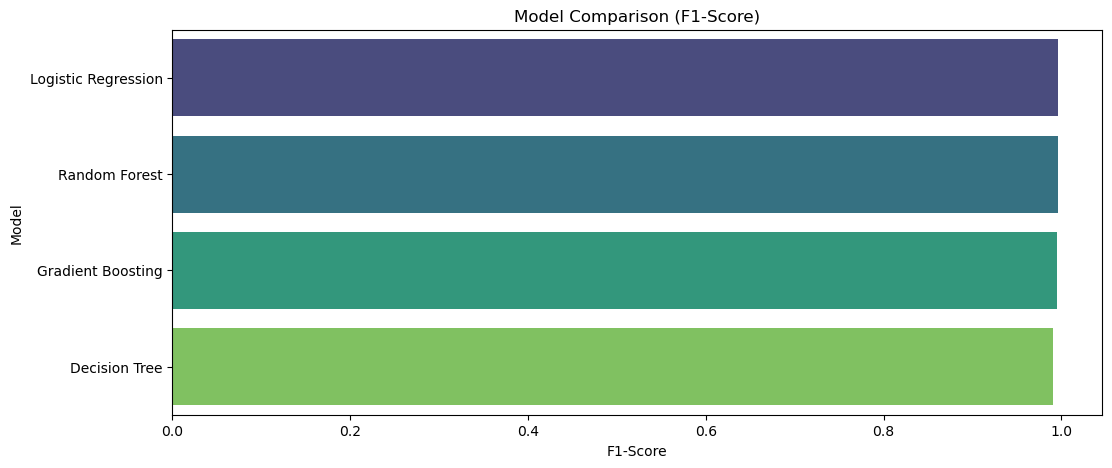

In [6]:
#Visualizing Performance
plt.figure(figsize=(12, 5))
sns.barplot(data=results_df, x='F1-Score', y='Model', palette='viridis')
plt.title('Model Comparison (F1-Score)')
plt.savefig('model_comparison.png')
plt.show()

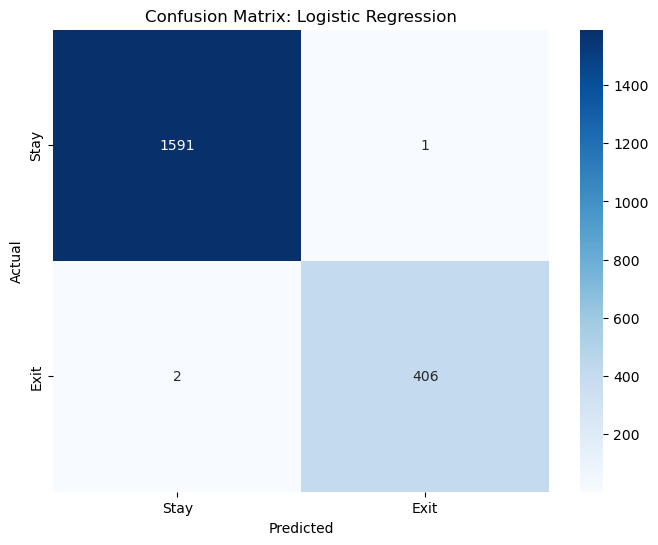

In [7]:
#Confusion Matrix
best_data = trained_models[best_model_name]
cm = confusion_matrix(y_test, best_data['predictions'])

plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Stay', 'Exit'], yticklabels=['Stay', 'Exit'])
plt.title(f'Confusion Matrix: {best_model_name}')
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.savefig('confusion_matrix.png')
plt.show()

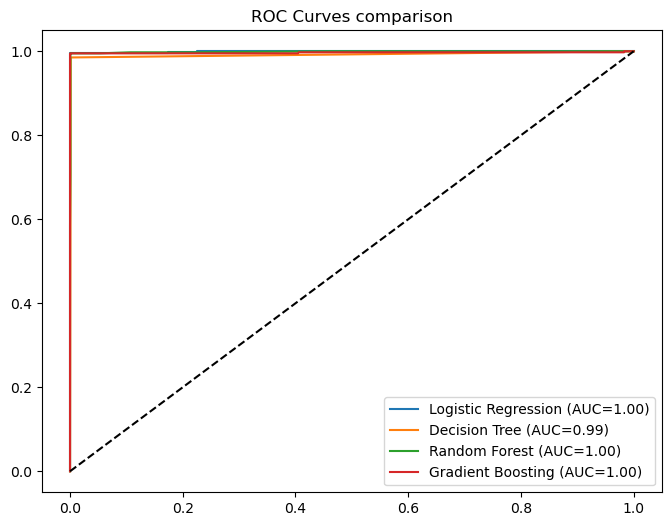

In [8]:
#ROC Curves
plt.figure(figsize=(8, 6))
for name in models.keys():
    fpr, tpr, _ = roc_curve(y_test, trained_models[name]['probabilities'])
    plt.plot(fpr, tpr, label=f"{name} (AUC={roc_auc_score(y_test, trained_models[name]['probabilities']):.2f})")

plt.plot([0, 1], [0, 1], 'k--')
plt.title('ROC Curves comparison')
plt.legend()
plt.savefig('roc_curves.png')
plt.show()

In [11]:
#Feature Importance
best_model = trained_models[best_model_name]['model']
if hasattr(best_model, 'feature_importances_'):
    importances = pd.Series(best_model.feature_importances_, index=X.columns).sort_values(ascending=False)
    plt.figure(figsize=(10, 6))
    importances.head(10).plot(kind='barh', color='skyblue').invert_yaxis()
    plt.title('Top 10 Predictive Features')
    plt.savefig('feature_importance.png')

    plt.show()

In [12]:
#Generate PDF ML Report
try:
    from fpdf import FPDF
    
    class PDF(FPDF):
        def header(self):
            self.set_font('Arial', 'B', 15)
            self.cell(0, 10, 'Machine Learning Churn Prediction Report', 0, 1, 'C')
            self.ln(10)

    pdf = PDF()
    pdf.add_page()
    pdf.set_font("Arial", size=12)

    # Performance Data
    pdf.cell(200, 10, txt=f"Best Model: {best_model_name}", ln=True)
    pdf.ln(5)
    
    for index, row in results_df.iterrows():
        text = f"{row['Model']}: Accuracy={row['Accuracy']:.2f}, F1={row['F1-Score']:.2f}"
        pdf.cell(0, 10, txt=text, ln=True)

    pdf.ln(10)
    pdf.multi_cell(0, 10, txt="CONCLUSIONS:\n1. The model identifies high-risk customers based on behavior.\n2. Accuracy and Recall are prioritized to minimize false negatives.\n3. This model is ready for deployment in the retention dashboard.")

    pdf.output("ML_Model_Report.pdf")
    print(" PDF Report 'ML_Model_Report.pdf' generated!")
except ImportError:
    print(" fpdf not installed. Run !pip install fpdf")

 PDF Report 'ML_Model_Report.pdf' generated!


In [13]:
#Export & Save
results_df.to_csv('model_performance_results.csv', index=False)

# If in Jupyter, this saves locally. If in Colab, use files.download
print("CSV, PNGs, and PDF Report are ready.")

CSV, PNGs, and PDF Report are ready.
